In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [14]:
import numpy as np
import scipy.stats as stats
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib as mpl
import pandas as pd

from bgspy.models import BGSModel 
from bgspy.genome import Genome
from bgspy.data import GenomeData, get_accessible_from_seqs
from bgspy.likelihood import InterpolatedMLE

2022-07-29 09:23:37.385119: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200

In [18]:
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=['chr10'])
g.load_annot("../data/annotation/conserved_phastcons_thresh0.bed.gz")
g.load_recmap("../data/annotation/hapmap_genetic_map.txt")

load_bed_annotation(): ignored chr12, chr4, chr13, chr14, chr8, chr1, chr7, chr17, chr6, chr3, chr20, chr15, chr11, chr2, chr5, chr22, chr18, chr19, chr16, chr21, chr9
ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)
RecMap._readmap() ignored chr12, chr4, chr13, chr14, chr8, chrX, chr1, chr7, chr17, chr6, chr3, chr20, chr15, chr11, chr2, chr5, chr22, chr18, chr19, chr16, chr21, chr9


In [19]:
gd = GenomeData(g)
gd.load_counts_dir('../data/hg1k_counts/')
gd.load_neutral_masks('../data/annotation/neutral_phastcons_genes_with_introns.bed.gz')
gd.load_accessibile_masks('../data/annotation/no_centro.bed')

In [20]:
g.seqlens

{'chr10': 133797422}

In [21]:
gd.stats()

{'chr10': (0.6283063361265661, 0.9581456808637165)}

In [22]:
gd.load_fasta('../data/annotation/hg38.fa.gz')

In [23]:
bins, pi = gd.bin_pi(width=1e6, filter_neutral=True, filter_accessible=True)

using neutral masks...
using accessibility masks...


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


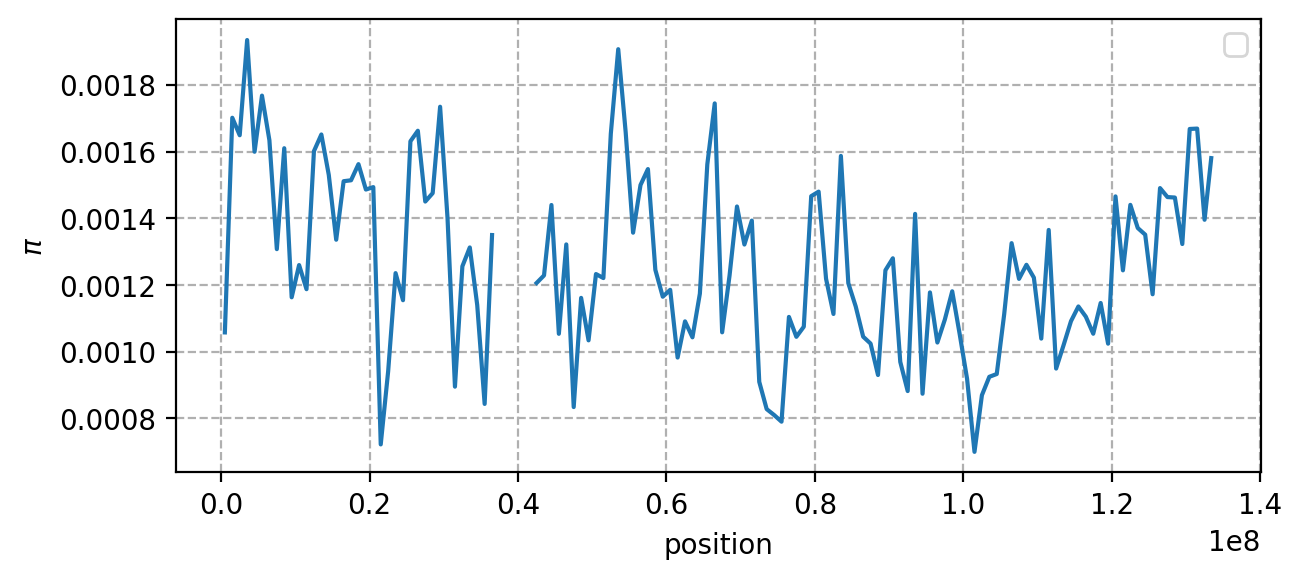

In [27]:
fig, ax = plt.subplots(figsize=(7, 3))

x, y = pi['chr10'].pairs
ax.plot(x, y)

ax.set_xlabel('position')
ax.set_ylabel('$\pi$')
ax.legend()
ax.grid(linestyle='dashed')

## B Maps

In [28]:
pkl_b_file = '../data/bmaps/bgspy/bmap_hg38_6x7grid_10000step_chr10.pkl'
m = BGSModel.load(pkl_b_file)
g = m.genome

In [60]:
wind = 1e6
bins, Y = gd.bin_reduce(wind, merge=True, filter_accessible=True, filter_neutral=True)

using neutral masks...
using accessibility masks...


In [119]:
Y.shape

(134, 2)

In [61]:
B = m.BScores.bin_means(bins).B['chr10']
Bp = m.BpScores.bin_means(bins).B['chr10']

In [120]:
mleB = InterpolatedMLE(m.w, m.t, B, (-5, -1))
mleBp = InterpolatedMLE(m.w, m.t, Bp, (-5, -1))

In [121]:
mleB.fit(Y, nruns=100, ncores=70)
mleBp.fit(Y, nruns=100, ncores=70)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.69it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.34it/s]

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.000e-10 3.981e-10 1.585e-09 6.310e-09 2.512e-08 1.000e-07] (before interpolation)
  t grid: [1.000e-05 4.642e-05 2.154e-04 1.000e-03 4.642e-03 2.154e-02 1.000e-01]
MLEs:
  pi0 = 0.001715
  W = [[1.000e-07]
    [1.000e-07]
    [1.000e-07]
    [4.177e-10]
    [1.000e-10]
    [1.199e-08]
    [3.020e-09]]
 negative log-likelihood: 315187827223.7108

In [122]:
def meanscale(x):
    return x/np.nanmean(x)

using neutral masks...
using accessibility masks...


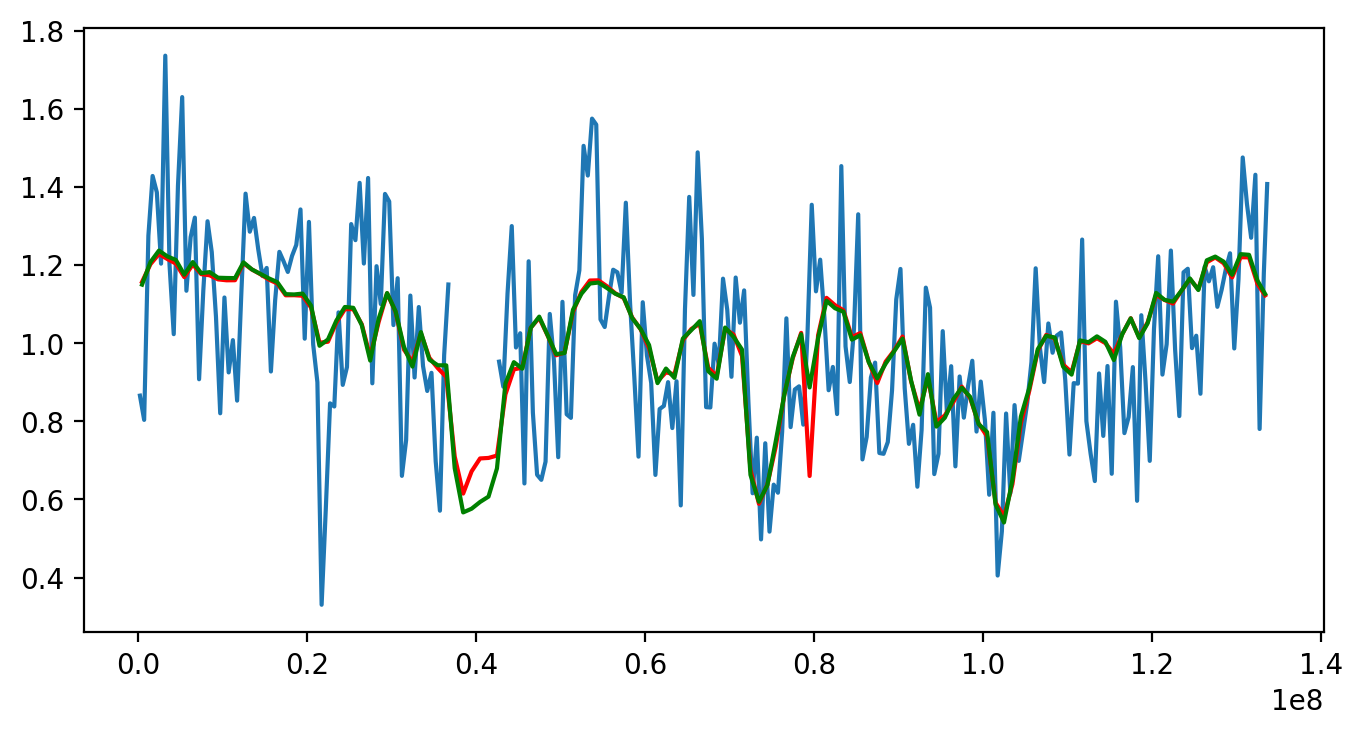

In [123]:
x, y = gd.bin_pi(5e5, filter_accessible=True, filter_neutral=True)[1]['chr10'].pairs
plt.plot(x, meanscale(y))

plt.plot(bins.midpoints['chr10'], meanscale(mleB.predict()), c='r', zorder=10)
plt.plot(bins.midpoints['chr10'], meanscale(mleBp.predict()), c='g', zorder=10)

pis = mle.predict(all=True)
#for i in range(mle.thetas_.shape[0]):
#    plt.plot(bins.midpoints['chr10'], pis[i, ...], c='0.22', alpha=0.1)



In [116]:
mleB

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.000e-10 3.981e-10 1.585e-09 6.310e-09 2.512e-08 1.000e-07] (before interpolation)
  t grid: [1.000e-05 4.642e-05 2.154e-04 1.000e-03 4.642e-03 2.154e-02 1.000e-01]
MLEs:
  pi0 = 0.001764
  W = [[1.000e-10]
    [1.000e-10]
    [1.000e-10]
    [1.000e-10]
    [6.109e-09]
    [6.880e-09]
    [8.734e-09]]
 negative log-likelihood: 315232376425.0403

In [117]:
mleBp

MLE (interpolated w): 6 x 7 x 1
  w grid: [1.000e-10 3.981e-10 1.585e-09 6.310e-09 2.512e-08 1.000e-07] (before interpolation)
  t grid: [1.000e-05 4.642e-05 2.154e-04 1.000e-03 4.642e-03 2.154e-02 1.000e-01]
MLEs:
  pi0 = 0.001691
  W = [[8.405e-08]
    [9.254e-08]
    [6.181e-09]
    [8.697e-09]
    [5.106e-09]
    [1.000e-10]
    [8.775e-09]]
 negative log-likelihood: 315213192193.41486

In [106]:
np.mean(mleBp.thetas_[:, 1:3]), np.mean(mleB.thetas_[:, 1:3])

(6.675656353672802e-08, 1e-10)

In [108]:
mleB.thetas_.mean(axis=0), mleBp.thetas_.mean(axis=0)

(array([2.68653106e-03, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
        4.95176760e-10, 2.22971303e-09, 5.11038049e-09, 1.65620432e-08]),
 array([1.70055522e-03, 5.69398369e-08, 7.65732902e-08, 5.13288339e-08,
        1.43732704e-09, 6.43607810e-10, 1.46868381e-09, 1.55566260e-08]))

In [112]:
mleB.mle_W.sum(), mleBp.mle_W.sum()

(1.8932801935219335e-08, 3.632471335715728e-08)

[]

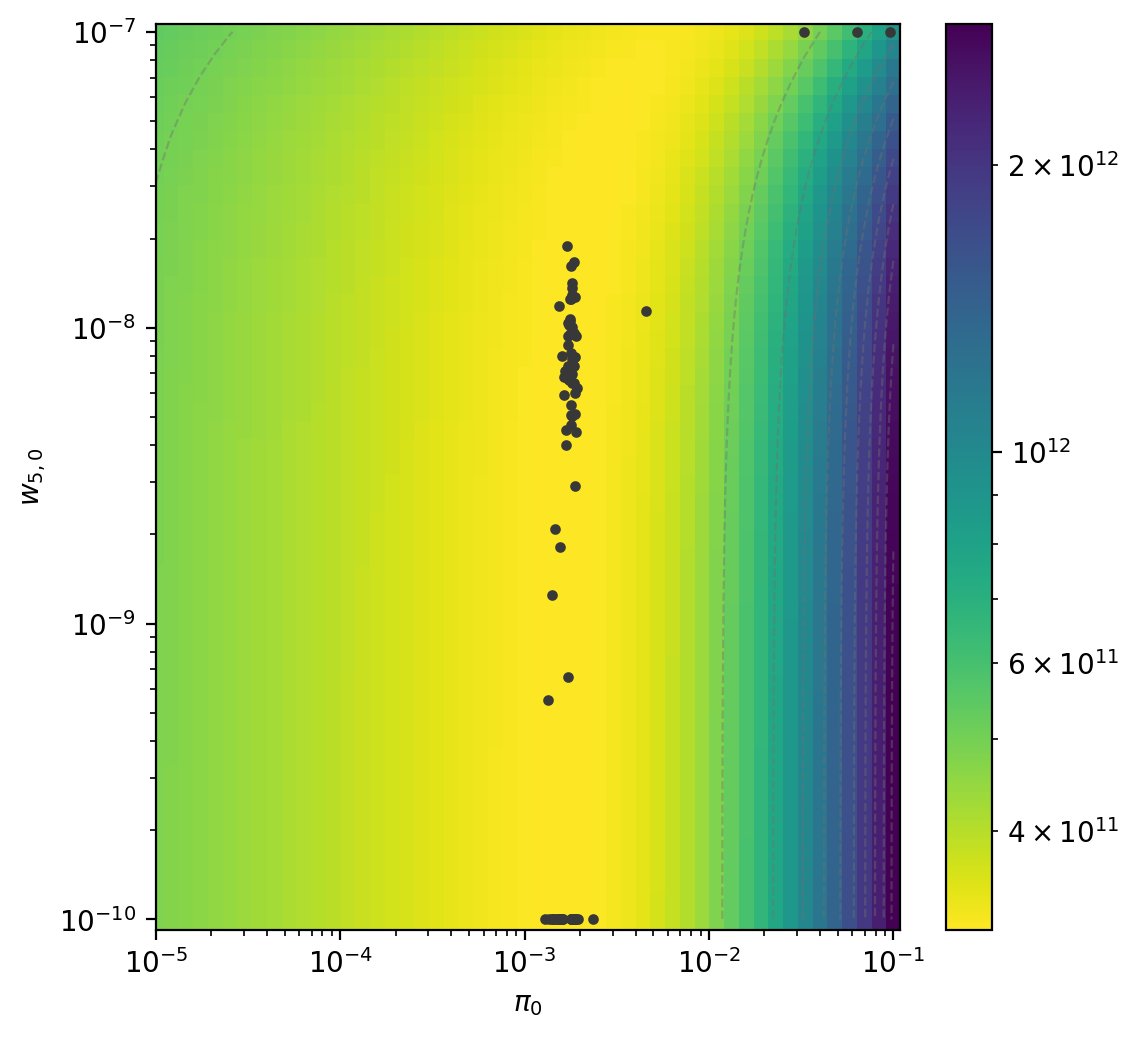

In [66]:
#pgrid = np.array([mle.theta_[0], 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, np.nan, np.nan])
pgrid = np.copy(mle.theta_)
pgrid[0] = np.nan
pgrid[6] = np.nan
grid, thetas, nlls = mle.profile_likelihood(Y, pgrid, nmesh=[51, None, None, None, None, None, 50, None])

cmap = mpl.cm.get_cmap('viridis_r')
p1, p2 = 0, 6

x, y, z = grid[p1], grid[p2], nlls.reshape((51, 50))
#x, y, z = np.log10(x), np.log10(y), np.log10(z)

#cmap = mpl.cm.get_cmap('viridis_r')

fig, ax = plt.subplots(figsize=(6, 6))
pm = ax.pcolormesh(x, y, z.T, cmap=cmap, norm=mpl.colors.LogNorm(vmin=np.quantile(z, 0.), vmax=z.max()))
ax.scatter(np.log10(mle.theta_[p1]), np.log10(mle.theta_[p2]), c='r')
cs = ax.contour(x, y, z.T, 10, colors='0.44', linestyles='dashed', linewidths=0.8, alpha=0.4)
for i in range(mle.thetas_.shape[0]):
    ax.scatter(mle.thetas_[i, p1], mle.thetas_[i, p2], s=8, c='0.22')
ax.clabel(cs, inline=True, fontsize=10)
plt.colorbar(pm)
plt.xlabel('$\pi_0$')
plt.ylabel('$w_{5, 0}$')
plt.loglog()

[]

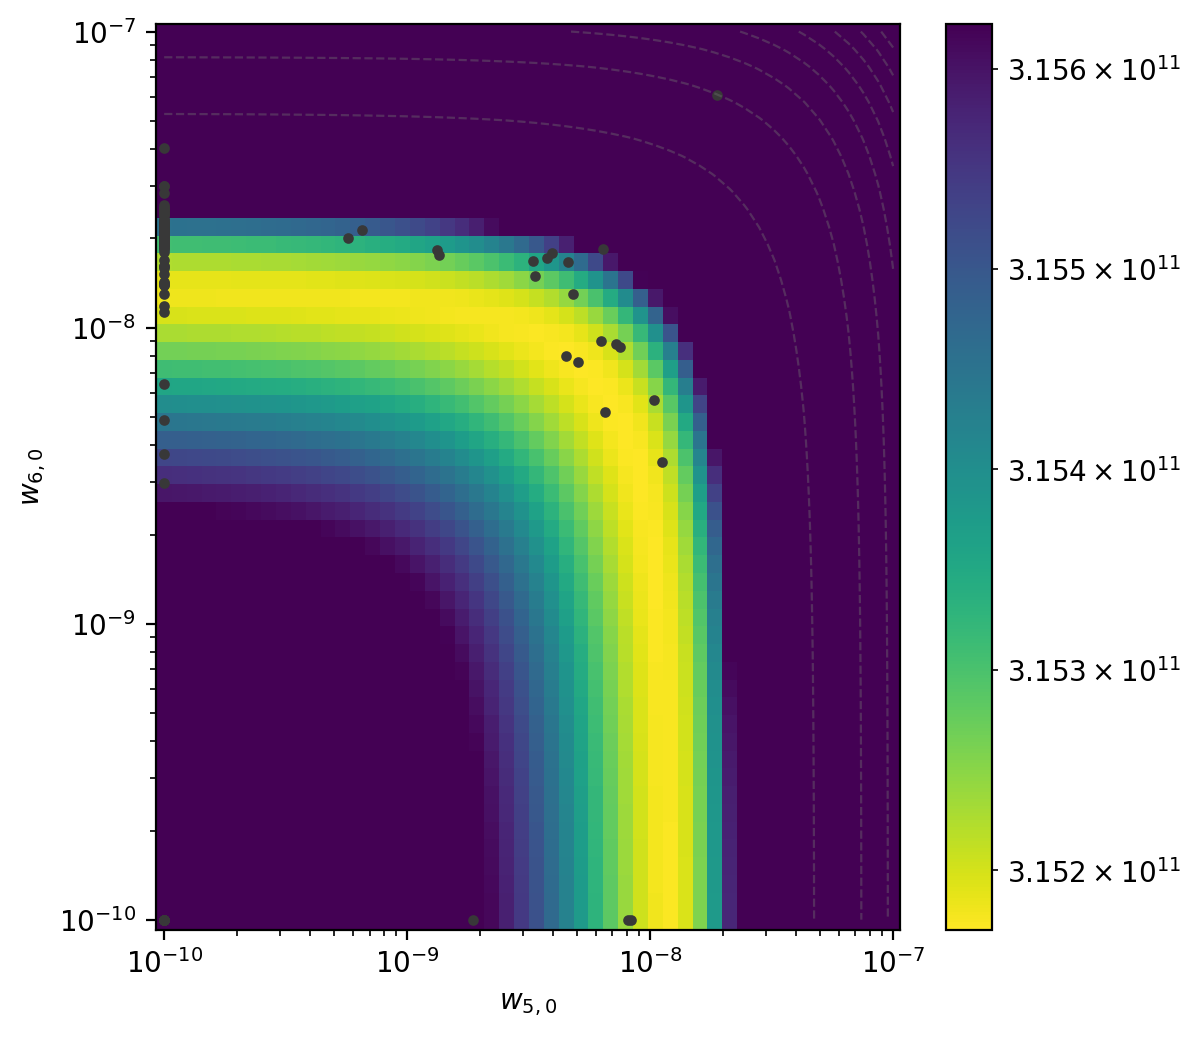

In [57]:
#pgrid = np.array([mle.theta_[0], 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, np.nan, np.nan])
pgrid = np.copy(mle.theta_)
pgrid[6:8] = np.nan
grid, thetas, nlls = mle.profile_likelihood(Y, pgrid, nmesh=[None, None, None, None, None, None, 50, 51])

x, y, z = grid[6], grid[7], nlls.reshape((50, 51))
#x, y, z = np.log10(x), np.log10(y), np.log10(z)

cmap = mpl.cm.get_cmap('viridis_r')

# note on transpose: this is because the number of columns of C must match number of elements of x
fig, ax = plt.subplots(figsize=(6, 6))
pm = ax.pcolormesh(x, y, z.T, cmap=cmap, norm=mpl.colors.LogNorm(vmin=np.quantile(z, 0.), vmax=np.quantile(z, 0.4)))
ax.scatter(np.log10(mle.theta_[6]), np.log10(mle.theta_[7]))
cs = ax.contour(x, y, z.T, 10, colors='0.44', linestyles='dashed', linewidths=0.8, alpha=0.4)
for i in range(mle.thetas_.shape[0]):
    ax.scatter(mle.thetas_[i, 6], mle.thetas_[i, 7], s=8, c='0.22')
ax.clabel(cs, inline=True, fontsize=10)
plt.colorbar(pm)
plt.xlabel('$w_{5, 0}$')
plt.ylabel('$w_{6, 0}$')
plt.loglog()